# PointNet Implementation
## for Semantic Segmentation

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.colors import LogNorm
import time as t
from time import perf_counter as cput
import scipy.constants as spc
import matplotlib.ticker as ticker

import sys
sys.path.append('/home/russbate/MLPionCollaboration/LCStudies/')
from util import resolution_util as ru
from util import plot_util as pu
from util import deep_set_util as dsu

plotpath = '/home/russbate/MLPionCollaboration/LCStudies/segmentation/Plots/October/'

## Declare GPUs and Import TensorFlow

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "6"

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## IMPORTANT ## ====== ## DISABLE EAGER EXECUTION WITH TensorFlow!! ##
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

print(tf.__version__)
print(keras.__version__)

2.6.0
2.6.0


## Load Data
### X = [Energy, Eta, Phi, rPerp]
### Y = [EM Energy, non EM Energy]
Notes:
This can be dramatically sped up with memory etc

In [3]:
t0 = cput()
Xraw = np.load('/data/atlas/rbate/Rho_X_20_files.npy', mmap_mode='r')[:,:,:]
Yraw = np.load('/data/atlas/rbate/Rho_Y_segm_20_files.npy', mmap_mode='r')[:,:,:]
print(Xraw.shape)
print(Yraw.shape)

X = np.lib.format.open_memmap('/data/atlas/rbate/XR_notebook.npy',
                             mode='w+', dtype=np.float32, shape=(Xraw.shape[0], Xraw.shape[1], 4))

Y = np.lib.format.open_memmap('/data/atlas/rbate/YR_notebook.npy',
                             mode='w+', dtype=np.float32, shape=(Yraw.shape[0], Yraw.shape[1], Yraw.shape[2]))
t1 = cput()

nz_mask = (Yraw[:,:,0] + Yraw[:,:,1]) != 0

print(np.shape(nz_mask))
print(np.count_nonzero(nz_mask))

# Make sure that non-zero elements are copied as zeros due to mis-match
X[np.invert(nz_mask),:] = 0

print('Time to load memory mapped data: '+str(t1-t0)+' (s)')

(355887, 1053, 5)
(355887, 1053, 2)
(355887, 1053)
100414129
Time to load memory mapped data: 1.1483811299985973 (s)


## Create Target

In [4]:
t0 = cput()
target_ratio = np.zeros(nz_mask.shape)

target_ratio[nz_mask] = Yraw[nz_mask,0] / (Yraw[nz_mask,0] + Yraw[nz_mask,1])

Y = target_ratio
t1 = cput()
print('Time to create targets: '+str(t1-t0)+' (s)')

Time to create targets: 11.60479781399772 (s)


#### Troubleshooting step:
 - [x] Make sure that target ratio and inputs have no nan values
 - [x] make sure that the X array is using the nz_mask so there are no mis-matches
   - This seems to be the problem, the mis-matches between values were yielding nans in the training!

## Point Normalization
 - [x] Convert to x,y,z
 - [x] Investigate Inputs (Rho_Pre-processing.ipynb)
 - [ ] Speed up the normalization process!
    -  Seems like the copy statements are killing speed!

In [5]:
t0 = cput()
X[:,:,1:4] = dsu.to_xyz(np.ndarray.copy(Xraw[:,:,1:4]), nz_mask)
t1 = cput()

## ENERGY ##
log_E_mask = Xraw[:,:,0] > 0
X[log_E_mask,0] = np.log(np.ndarray.copy(Xraw[log_E_mask,0]))

## X ##
X[:,:,1] = np.ndarray.copy(Xraw[:,:,1])/3000

## Y ##
X[:,:,2] = np.ndarray.copy(Xraw[:,:,2])/1000

## Z ##
X[:,:,3] = np.ndarray.copy(Xraw[:,:,3])/1000
t2 = cput()

print('Time to convert to xyz: {} (s)'.format(t1-t0))
print('Time to normalize: {} (s)'.format(t2-t1))
print('Total time: {} (s)'.format(t2-t0))
print('Target shape: {}'.format(Y.shape))
print('Input shape: {}'.format(X.shape))

(100414129, 3)
Time to convert to xyz: 82.74502446499537 (s)
Time to normalize: 31.163649232999887 (s)
Total time: 113.90867369799525 (s)
Target shape: (355887, 1053)
Input shape: (355887, 1053, 4)


## Time Distributed Model
PointNet Alpha:
 - [x] time distributed
 - [x] batch normalization
 - [x] regularizer
 
PointNet Beta:
 - [x] time distributed 

In [6]:
print(X.dtype)

float32


In [6]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    """Reference: https://keras.io/examples/vision/pointnet/#build-a-model"""

    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.identity = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.identity))

    def get_config(self):
        config = super(TransformerEncoder, self).get_config()
        config.update({"num_features": self.num_features, "l2reg_strength": self.l2reg})
        return config

def repeat_for_points(tensors):
    ''' y needs to be input shape tensor '''
    x, y = tensors
    reps = y.shape[-2]
    new_tens = tf.repeat(x, reps, axis=-2)
    return new_tens

def mat_mult(tensors):
    x, y = tensors
    return tf.linalg.matmul(x, y)

def cast_to_zero(tensors):
    ''' casts all values that should be zero to zero in the modified tensor '''
    mod_input, input_tens = tensors
    full_mask = tf.logical_not(tf.math.equal(input_tens, 0.))
    reduced_mask = tf.experimental.numpy.any(full_mask, axis=-1)
    reduced_mask = tf.cast(reduced_mask, dtype=tf.float32)
    reduced_mask = tf.expand_dims(reduced_mask, axis=-1)
    return_tens = tf.math.multiply(mod_input, reduced_mask)
    return return_tens

def tdist_block(x, mask, size: int, number: str):
    dense = layers.Dense(size)
    x = layers.TimeDistributed(dense, name='t_dist_'+number)(x, mask=mask)
    x = layers.Activation('relu', name='activation_'+number)(x)
    return x

def tdist_batchNorm(x, mask, size: int, number: str):
    dense = layers.Dense(size)
    x = layers.BatchNormalization(momentum=0.0, name='batchNorm_'+number)(dense)
    x = layers.TimeDistributed(x, name='t_dist_'+number)(x, mask=mask)
    x = layers.Activation('relu', name='activation_'+number)(x)
    return x

In [7]:
def PointNet_beta(shape=(None,None,4), name=None):
    inputs = keras.Input(shape=shape, name="input")

    mask_tens = layers.Masking(mask_value=0.0, input_shape=shape)(inputs)
    keras_mask = mask_tens._keras_mask

    #============= T-NET ====================================================#
    block_0 = tdist_block(inputs, mask=keras_mask, size=32, number='0')
    block_1 = tdist_block(block_0, mask=keras_mask, size=64, number='1')
    block_2 = tdist_block(block_1, mask=keras_mask, size=64, number='2')
    
    # mask outputs to zero
    block_2_masked = layers.Lambda(cast_to_zero, name='block_2_masked')([block_2, inputs])
    
    max_pool = layers.MaxPool1D(pool_size=shape[0], name='tnet_0_MaxPool')(block_2_masked)
    mlp_tnet_0 = layers.Dense(64, activation='relu', name='tnet_0_dense_0')(max_pool)
    mlp_tnet_1 = layers.Dense(32, activation='relu', name='tnet_0_dense_1')(mlp_tnet_0)
    
    vector_dense = layers.Dense(
        shape[1]*shape[1],
        kernel_initializer='zeros',
        bias_initializer=keras.initializers.Constant(np.eye(shape[1]).flatten()),
        name='pre_matrix_0'
    )(mlp_tnet_1)
    
    mat_layer = layers.Reshape((shape[1], shape[1]), name='matrix_0')(vector_dense)
    
    mod_inputs_0 = layers.Lambda(mat_mult, name='matrix_multiply_0')([inputs, mat_layer])
    #========================================================================#
    
    
    #=============== UPSCALE TO NEW FEATURE SPACE ===========================#
    block_3 = tdist_block(mod_inputs_0, mask=keras_mask, size=24, number='3')
    block_4 = tdist_block(block_3, mask=keras_mask, size=24, number='4')
    #========================================================================#

    
    #============= T-NET ====================================================#
    block_5 = tdist_block(block_4, mask=keras_mask, size=128, number='5')
    block_6 = tdist_block(block_5, mask=keras_mask, size=256, number='6')
    block_7 = tdist_block(block_6, mask=keras_mask, size=512, number='7')
    
    # mask outputs to zero
    block_7_masked = layers.Lambda(cast_to_zero, name='block_7_masked')([block_7, inputs])
    
    max_pool_1 = layers.MaxPool1D(pool_size=shape[0], name='tnet_1_MaxPool')(block_7_masked)
    mlp_tnet_2 = layers.Dense(512, activation='relu', name='tnet_1_dense_0')(max_pool_1)
    mlp_tnet_3 = layers.Dense(512, activation='relu', name='tnet_1_dense_1')(mlp_tnet_2)
    
    vector_dense_1 = layers.Dense(
        576,
        kernel_initializer='zeros',
        bias_initializer=keras.initializers.Constant(np.eye(24).flatten()),
        name='pre_matrix_1'
    )(mlp_tnet_3)
    
    mat_layer_1 = layers.Reshape((24, 24), name='matrix_1')(vector_dense_1)
    
    mod_features_1 = layers.Lambda(mat_mult, name='matrix_multiply_1')([block_4, mat_layer_1])
    #========================================================================#
    
    
    #================ MLP + MAXPOOL BLOCK ===================================#
    block_8 = tdist_block(mod_features_1, mask=keras_mask, size=128, number='8')
    block_9 = tdist_block(block_8, mask=keras_mask, size=256, number='9')
    block_10 = tdist_block(block_9, mask=keras_mask, size=512, number='10')
    
    block_10_masked = layers.Lambda(cast_to_zero, name='block_10_masked')(
    [block_10, inputs]
    )
    
    max_pool_2 = layers.MaxPool1D(pool_size=shape[-2], name='global_maxpool')(block_10_masked)
    #========================================================================#

    max_poo_block = layers.Lambda(repeat_for_points, name='mp_block')([max_pool_2, inputs])
    
    block_11 = layers.Concatenate(axis=-1, name='concatenation')([max_poo_block, mod_features_1])
    
    
    block_12 = tdist_block(block_11, mask=keras_mask, size=536, number='12')
    dropout_0 = layers.Dropout(rate=.2)(block_12)
    block_13 = tdist_block(dropout_0, mask=keras_mask, size=536, number='13')
    dropout_1 = layers.Dropout(rate=.2)(block_13)
    block_14 = tdist_block(dropout_1, mask=keras_mask, size=256, number='14')
    dropout_2 = layers.Dropout(rate=.2)(block_14)
    block_15 = tdist_block(dropout_2, mask=keras_mask, size=128, number='15')
    dropout_3 = layers.Dropout(rate=.2)(block_15)
    
    last_dense = layers.Dense(1)
    last_time = layers.TimeDistributed(last_dense, name='last_tdist')(dropout_3, mask=keras_mask)
    last_act = layers.Activation('sigmoid', name="last_act")(last_time)

    return keras.Model(inputs=inputs, outputs=last_act, name=name)

In [9]:
pnet_beta = PointNet_beta(shape=(X.shape[1],4), name='PointNet_Beta')

pnet_beta.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.005))
pnet_beta.summary()

Model: "PointNet_Beta"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 1053, 4)]    0                                            
__________________________________________________________________________________________________
t_dist_0 (TimeDistributed)      (None, 1053, 32)     160         input[0][0]                      
__________________________________________________________________________________________________
activation_0 (Activation)       (None, 1053, 32)     0           t_dist_0[0][0]                   
__________________________________________________________________________________________________
t_dist_1 (TimeDistributed)      (None, 1053, 64)     2112        activation_0[0][0]               
______________________________________________________________________________________

## Set up Datasets and Shuffle

In [8]:
train_num, val_num, test_num = dsu.tvt_num(X, tvt=(70,15,15))
print('Number of training samples: '+str(train_num))
print('Number of validation samples: '+str(val_num))
print('Number of test samples: '+str(test_num))

Number of training samples: 249121
Number of validation samples: 53383
Number of test samples: 53383


### Using TF DataSets

In [30]:
# dataset = tf.data.Dataset.from_tensors((X,Y))

# dat_tr = dataset.skip(val_num+test_num)
# dat_test = dataset.take(test_num+val_num)
# dat_val = dat_test.skip(test_num)
# dat_test = dataset.take(test_num)

# print(dat_tr.cardinality())
# print(dat_test.cardinality())
# print(dat_val.cardinality())

In [61]:
# Nbatches = int(np.ceil(1785/382))
# print(Nbatches)
# batch_size=int(np.floor(1785/Nbatches))
# print(batch_size)

# dat_tr = dat_tr.batch(Nbatches, drop_remainder=True)
# dat_val = dat_val.batch(Nbatches, drop_remainder=True)
# dat_test = dat_test.batch(Nbatches, drop_remainder=True)

### Using numpy arrays

In [9]:
Y = np.atleast_3d(Y)

X_train = X[:train_num,:,:]
Y_train = Y[:train_num,:]

X_val = X[train_num:train_num+val_num,:,:]
Y_val = Y[train_num:train_num+val_num,:]

X_test = X[train_num+val_num:,:,:]
Y_test = Y[train_num+val_num:,:]

In [10]:
nz_test_mask = np.ndarray.copy(nz_mask[train_num+val_num:,:])
print(Y_train.shape)
print(X_train.shape)

(249121, 1053, 1)
(249121, 1053, 4)


### Train

In [16]:
t0 = cput()

beta_hist = pnet_beta.fit(x=X_train, y=Y_train,
                           epochs=30,
                           batch_size=250,
                           validation_data=(X_val, Y_val),
                           verbose=1)

t1 = cput()

Train on 249121 samples, validate on 53383 samples
Epoch 1/30


2022-01-24 16:51:21.676485: W tensorflow/core/common_runtime/bfc_allocator.cc:463] Allocator (GPU_0_bfc) ran out of memory trying to allocate 538.26MiB (rounded to 564408064)requested by op training/Adam/gradients/gradients/t_dist_14/dense_13/MatMul_grad/MatMul
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-01-24 16:51:21.676561: I tensorflow/core/common_runtime/bfc_allocator.cc:1013] BFCAllocator dump for GPU_0_bfc
2022-01-24 16:51:21.676595: I tensorflow/core/common_runtime/bfc_allocator.cc:1020] Bin (256): 	Total Chunks: 56, Chunks in use: 56. 14.0KiB allocated for chunks. 14.0KiB in use in bin. 824B client-requested in use in bin.
2022-01-24 16:51:21.676621: I tensorflow/core/common_runtime/bfc_allocator.cc:1020] Bin (512): 	Total Chunks: 13, Chunks in use: 12. 6.8KiB allocated for chunks. 6.0KiB in use in bin. 5.8KiB cl

ResourceExhaustedError: OOM when allocating tensor with shape[263250,536] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node training/Adam/gradients/gradients/t_dist_14/dense_13/MatMul_grad/MatMul}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.


In [ ]:
print('Time to train: {} (s)'.format(t1-t0))
print('{} (min)'.format((t1-t0)/60))
print('{} (hour)'.format((t1-t0)/3600))

### Plot Loss Curves

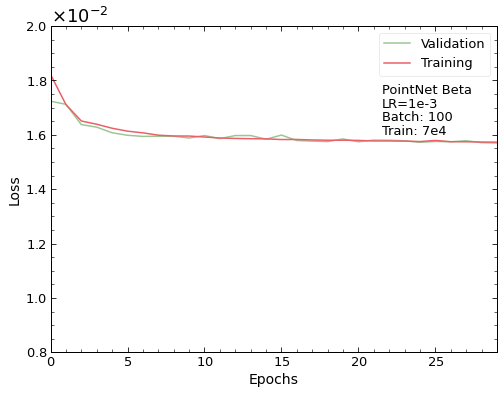

In [42]:
plot_dict = beta_hist

fig = plt.figure(figsize=(8,6))
plt.plot(plot_dict.history['val_loss'], label="Validation")
plt.plot(plot_dict.history['loss'], label="Training")
plt.ylim(0.008,0.02)
plt.yticks(fontsize=13)
plt.xlim(0,len(plot_dict.history['loss'])-1)
plt.xticks(fontsize=13)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='upper right', ncol=1, frameon=True, fancybox=True)
plt.text(21.5, 1.75e-2, 'PointNet Beta', fontsize=13)
plt.text(21.5, 1.7e-2, 'LR=1e-3', fontsize=13)
plt.text(21.5, 1.65e-2, 'Batch: 100', fontsize=13)
plt.text(21.5, 1.6e-2, 'Train: 7e4', fontsize=13)
# plt.savefig('Plots/January22/LossCurves_pnetBeta_LR1e-3_batch100__Train7e4_2022-01-12.png',
#         format='png')
plt.show()

### Predictions

In [78]:
t0 = cput()
predictions_beta = pnet2.predict(X_test)
t1 = cput()
print(predictions_beta.shape)
print('Time to make predictions: '+str(t1-t0)+' (s)')

(15000, 1053, 1)
Time to make predictions: 11.357352143153548 (s)


### Predictions Hist

<Figure size 799.992x599.976 with 0 Axes>

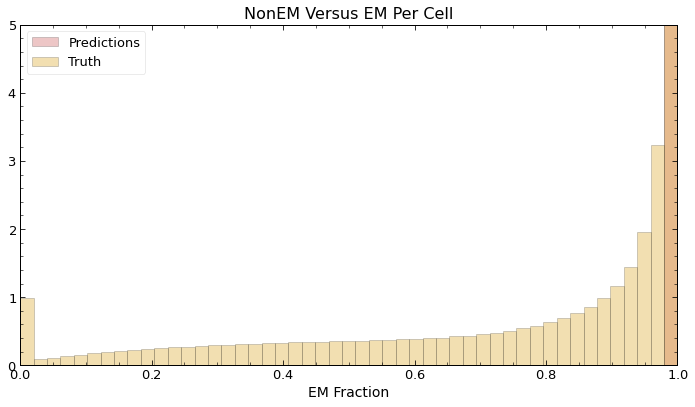

In [79]:
predictions_beta = predictions_beta.reshape(predictions_beta.shape[0], predictions_beta.shape[1])
Y_test = Y_test.reshape(Y_test.shape[0], Y_test.shape[1])

plt.cla(); plt.clf()
fig = plt.figure(figsize=(10,6))

EMbins = np.linspace(0,1,50, endpoint=True)
plt.hist(predictions_beta[nz_test_mask], color='indianred', bins=EMbins, density=True,
        alpha=.35, edgecolor='black', label='Predictions')
plt.hist(Y_test[nz_test_mask], color='goldenrod', bins=EMbins, density=True,
        alpha=.35, edgecolor='black', label='Truth')
plt.title('NonEM Versus EM Per Cell', fontsize=16)
plt.xlabel('EM Fraction', fontsize=14)
plt.xlim(0,1)
plt.ylim(0,5)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(loc='upper left', frameon=True, fancybox=True, prop={'size': 13})
plt.tight_layout()
# plt.savefig('Plots/January22/pnetBeta_predsVsTruth_12-01-2022.png', format='png')
plt.show()

## More Models

In [11]:
def PointNet_delta(shape=(None,4), name=None):
    inputs = keras.Input(shape=shape, name="input")

    mask_tens = layers.Masking(mask_value=0.0, input_shape=shape)(inputs)
    keras_mask = mask_tens._keras_mask

    #============= T-NET ====================================================#
    block_0 = tdist_block(inputs, mask=keras_mask, size=32, number='0')
    block_1 = tdist_block(block_0, mask=keras_mask, size=64, number='1')
    block_2 = tdist_block(block_1, mask=keras_mask, size=64, number='2')
    
    # mask outputs to zero
    block_2_masked = layers.Lambda(cast_to_zero, name='block_2_masked')([block_2, inputs])
    
    max_pool = layers.MaxPool1D(pool_size=shape[0], name='tnet_0_MaxPool')(block_2_masked)
    mlp_tnet_0 = layers.Dense(64, activation='relu', name='tnet_0_dense_0')(max_pool)
    mlp_tnet_1 = layers.Dense(32, activation='relu', name='tnet_0_dense_1')(mlp_tnet_0)
    
    vector_dense = layers.Dense(
        shape[1]*shape[1],
        kernel_initializer='zeros',
        bias_initializer=keras.initializers.Constant(np.eye(shape[1]).flatten()),
        name='pre_matrix_0'
    )(mlp_tnet_1)
    
    mat_layer = layers.Reshape((shape[1], shape[1]), name='matrix_0')(vector_dense)
    
    mod_inputs_0 = layers.Lambda(mat_mult, name='matrix_multiply_0')([inputs, mat_layer])
    #========================================================================#
    
    
    #=============== UPSCALE TO NEW FEATURE SPACE ===========================#
    block_3 = tdist_block(mod_inputs_0, mask=keras_mask, size=16, number='3')
    block_4 = tdist_block(block_3, mask=keras_mask, size=16, number='4')
    #========================================================================#

    
    #============= T-NET ====================================================#
    block_5 = tdist_block(block_4, mask=keras_mask, size=64, number='5')
    block_6 = tdist_block(block_5, mask=keras_mask, size=128, number='6')
    block_7 = tdist_block(block_6, mask=keras_mask, size=256, number='7')
    
    # mask outputs to zero
    block_7_masked = layers.Lambda(cast_to_zero, name='block_7_masked')([block_7, inputs])
    
    max_pool_1 = layers.MaxPool1D(pool_size=shape[0], name='tnet_1_MaxPool')(block_7_masked)
    mlp_tnet_2 = layers.Dense(256, activation='relu', name='tnet_1_dense_0')(max_pool_1)
    mlp_tnet_3 = layers.Dense(256, activation='relu', name='tnet_1_dense_1')(mlp_tnet_2)
    
    vector_dense_1 = layers.Dense(
        256,
        kernel_initializer='zeros',
        bias_initializer=keras.initializers.Constant(np.eye(16).flatten()),
        name='pre_matrix_1'
    )(mlp_tnet_3)
    
    mat_layer_1 = layers.Reshape((16, 16), name='matrix_1')(vector_dense_1)
    
    mod_features_1 = layers.Lambda(mat_mult, name='matrix_multiply_1')([block_4, mat_layer_1])
    #========================================================================#
    
    
    #================ MLP + MAXPOOL BLOCK ===================================#
    block_8 = tdist_block(mod_features_1, mask=keras_mask, size=64, number='8')
    block_9 = tdist_block(block_8, mask=keras_mask, size=128, number='9')
    block_10 = tdist_block(block_9, mask=keras_mask, size=256, number='10')
    
    block_10_masked = layers.Lambda(cast_to_zero, name='block_10_masked')(
    [block_10, inputs]
    )
    
    max_pool_2 = layers.MaxPool1D(pool_size=shape[-2], name='global_maxpool')(block_10_masked)
    #========================================================================#

    max_pool_block = layers.Lambda(repeat_for_points, name='mp_block')([max_pool_2, inputs])
    
    block_11 = layers.Concatenate(axis=-1, name='concatenation')([max_pool_block, mod_features_1])
    
    
    block_12 = tdist_block(block_11, mask=keras_mask, size=272, number='12')
    dropout_0 = layers.Dropout(rate=.2)(block_12)
    block_13 = tdist_block(dropout_0, mask=keras_mask, size=272, number='13')
    dropout_1 = layers.Dropout(rate=.2)(block_13)
    block_14 = tdist_block(dropout_1, mask=keras_mask, size=128, number='14')
    dropout_2 = layers.Dropout(rate=.2)(block_14)
    block_15 = tdist_block(dropout_2, mask=keras_mask, size=64, number='15')
    dropout_3 = layers.Dropout(rate=.2)(block_15)
    
    last_dense = layers.Dense(1)
    last_time = layers.TimeDistributed(last_dense, name='last_tdist')(dropout_3, mask=keras_mask)
    last_act = layers.Activation('sigmoid', name="last_act")(last_time)

    return keras.Model(inputs=inputs, outputs=last_act, name=name)

In [12]:
pnet_delta = PointNet_delta(shape=(X.shape[1], 4), name='PointNet_Delta')

pnet_delta.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.001))
pnet_delta.summary()

Model: "PointNet_Delta"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 1053, 4)]    0                                            
__________________________________________________________________________________________________
t_dist_0 (TimeDistributed)      (None, 1053, 32)     160         input[0][0]                      
__________________________________________________________________________________________________
activation_0 (Activation)       (None, 1053, 32)     0           t_dist_0[0][0]                   
__________________________________________________________________________________________________
t_dist_1 (TimeDistributed)      (None, 1053, 64)     2112        activation_0[0][0]               
_____________________________________________________________________________________

In [13]:
t0 = cput()

delta_hist = pnet_delta.fit(x=X_train, y=Y_train,
                           epochs=30,
                           batch_size=300,
                           validation_data=(X_val, Y_val),
                           verbose=1)

t1 = cput()

Train on 249121 samples, validate on 53383 samples
Epoch 1/30


2022-01-24 20:38:01.926733: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9672 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:b1:00.0, compute capability: 7.5
2022-01-24 20:38:05.216927: I tensorflow/stream_executor/cuda/cuda_dnn.cc:381] Loaded cuDNN version 8204


249121/249121 [==============================] - ETA: 0s - loss: 0.0182

/usr/local/lib/python3.8/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


249121/249121 [==============================] - 553s 2ms/sample - loss: 0.0182 - val_loss: 0.0175
Epoch 2/30
249121/249121 [==============================] - 537s 2ms/sample - loss: 0.0167 - val_loss: 0.0165
Epoch 3/30
249121/249121 [==============================] - 537s 2ms/sample - loss: 0.0164 - val_loss: 0.0162
Epoch 4/30
249121/249121 [==============================] - 537s 2ms/sample - loss: 0.0162 - val_loss: 0.0161
Epoch 5/30
249121/249121 [==============================] - 537s 2ms/sample - loss: 0.0161 - val_loss: 0.0160
Epoch 6/30
249121/249121 [==============================] - 537s 2ms/sample - loss: 0.0160 - val_loss: 0.0161
Epoch 7/30
249121/249121 [==============================] - 537s 2ms/sample - loss: 0.0160 - val_loss: 0.0160
Epoch 8/30
249121/249121 [==============================] - 541s 2ms/sample - loss: 0.0159 - val_loss: 0.0157
Epoch 9/30
249121/249121 [==============================] - 547s 2ms/sample - loss: 0.0159 - val_loss: 0.0157
Epoch 10/30
249121/24

In [14]:
print('Time to train: {} (s)'.format(t1-t0))
print('{} (min)'.format((t1-t0)/60))
print('{} (hour)'.format((t1-t0)/3600))

Time to train: 16229.806645702993 (s)
270.4967774283832 (min)
4.508279623806387 (hour)


### Loss Curves

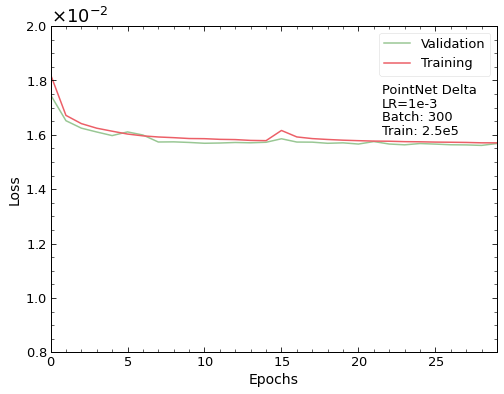

In [20]:
plot_dict = delta_hist

fig = plt.figure(figsize=(8,6))
plt.plot(plot_dict.history['val_loss'], label="Validation")
plt.plot(plot_dict.history['loss'], label="Training")
plt.ylim(0.008,0.02)
plt.yticks(fontsize=13)
plt.xlim(0,len(plot_dict.history['loss'])-1)
plt.xticks(fontsize=13)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='upper right', ncol=1, frameon=True, fancybox=True)
plt.text(21.5, 1.75e-2, 'PointNet Delta', fontsize=13)
plt.text(21.5, 1.7e-2, 'LR=1e-3', fontsize=13)
plt.text(21.5, 1.65e-2, 'Batch: 300', fontsize=13)
plt.text(21.5, 1.6e-2, 'Train: 2.5e5', fontsize=13)
# plt.savefig('Plots/January22/LossCurves_pnetDelta_LR1e-3_batch300__Train2.5e5_2022-01-24.png',
#         format='png')
plt.show()

### Predictions

In [17]:
t0 = cput()
predictions_delta = pnet_delta.predict(X_test)
t1 = cput()
print(predictions_delta.shape)
print('Time to make predictions: '+str(t1-t0)+' (s)')

(53383, 1053, 1)
Time to make predictions: 20.766478339006426 (s)


### Predictions Hist

<Figure size 799.992x599.976 with 0 Axes>

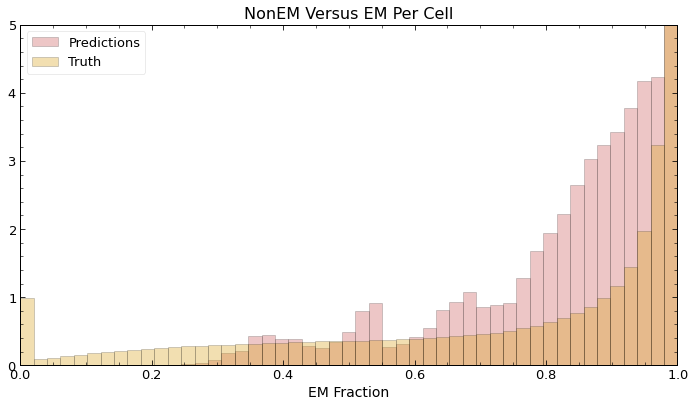

In [21]:
predictions_delta = predictions_delta.reshape(predictions_delta.shape[0],
                                              predictions_delta.shape[1])
Y_test = Y_test.reshape(Y_test.shape[0], Y_test.shape[1])

plt.cla(); plt.clf()
fig = plt.figure(figsize=(10,6))

EMbins = np.linspace(0,1,50, endpoint=True)
plt.hist(predictions_delta[nz_test_mask], color='indianred', bins=EMbins, density=True,
        alpha=.35, edgecolor='black', label='Predictions')
plt.hist(Y_test[nz_test_mask], color='goldenrod', bins=EMbins, density=True,
        alpha=.35, edgecolor='black', label='Truth')
plt.title('NonEM Versus EM Per Cell', fontsize=16)
plt.xlabel('EM Fraction', fontsize=14)
plt.xlim(0,1)
plt.ylim(0,5)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(loc='upper left', frameon=True, fancybox=True, prop={'size': 13})
plt.tight_layout()
# plt.savefig('Plots/January22/predsHist_pnetDelta_LR1e-3_batch300__Train2.5e5_2022-01-24.png',
#         format='png')
plt.show()

#### Save Model

In [24]:
# pnet_delta.save('Models/pndet_delta_trainedOn_355887_Rho_16_features.h5')

### Visualize Computational Graph

In [39]:
%load_ext tensorboard

from datetime import datetime
from packaging import version

import tensorboard
tensorboard.__version__

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


'2.6.0'

In [37]:
rm -rf ./logs/

In [44]:
%reload_ext tensorboard

In [51]:
%tensorboard --logdir tb_logs --host 127.0.0.1

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
Error: Must not specify both --host and --bind_all.

In [43]:
!kill 60113

# Multi-GPU Training
 - Note this half of the notebook is set up different and should be run entirely separately. Re-start the kernel to execute below

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.colors import LogNorm
import time as t
from time import perf_counter as cput
import scipy.constants as spc
import matplotlib.ticker as ticker

import sys
sys.path.append('/home/russbate/MLPionCollaboration/LCStudies/')
from util import resolution_util as ru
from util import plot_util as pu
from util import deep_set_util as dsu

## Data

### Load Data Files

In [6]:
t0 = cput()
Xraw = np.load('/data/atlas/rbate/Rho_X_20_files.npy', mmap_mode='r')[:100000,:,:]
Yraw = np.load('/data/atlas/rbate/Rho_Y_segm_20_files.npy', mmap_mode='r')[:100000,:,:]
print(Xraw.shape)
print(Yraw.shape)

X = np.lib.format.open_memmap('/data/atlas/rbate/XR_notebook.npy',
                             mode='w+', dtype=np.float64, shape=(Xraw.shape[0], Xraw.shape[1], 4))

Y = np.lib.format.open_memmap('/data/atlas/rbate/YR_notebook.npy',
                             mode='w+', dtype=np.float64, shape=(Yraw.shape[0], Yraw.shape[1], Yraw.shape[2]))
t1 = cput()

nz_mask = (Yraw[:,:,0] + Yraw[:,:,1]) != 0

print(np.shape(nz_mask))
print(np.count_nonzero(nz_mask))

# Make sure that non-zero elements are copied as zeros due to mis-match
X[np.invert(nz_mask),:] = 0

print('Time to load memory mapped data: '+str(t1-t0)+' (s)')

(100000, 1053, 5)
(100000, 1053, 2)
(100000, 1053)
28244338
Time to load memory mapped data: 0.4914599843323231 (s)


### Create Target

In [7]:
t0 = cput()
target_ratio = np.zeros(nz_mask.shape)

target_ratio[nz_mask] = Yraw[nz_mask,0] / (Yraw[nz_mask,0] + Yraw[nz_mask,1])

Y = target_ratio
t1 = cput()
print('Time to create targets: '+str(t1-t0)+' (s)')

Time to create targets: 2.487315518781543 (s)


### Normalize Points

In [8]:
print(X[nz_mask, :3].shape)

t0 = cput()
X[:,:,1:4] = dsu.to_xyz(np.ndarray.copy(Xraw[:,:,1:4]), nz_mask)
t1 = cput()

## ENERGY ##
log_E_mask = Xraw[:,:,0] > 0
X[log_E_mask,0] = np.log(np.ndarray.copy(Xraw[log_E_mask,0]))

## X ##
X[:,:,1] = np.ndarray.copy(Xraw[:,:,1])/3000

## Y ##
X[:,:,2] = np.ndarray.copy(Xraw[:,:,2])/1000

## Z ##
X[:,:,3] = np.ndarray.copy(Xraw[:,:,3])/1000
t2 = cput()

print('Time to convert to xyz: '+str(t1-t0)+' (s)')
print('Time to normalize: '+str(t2-t1)+' (s)')
print('Total time: '+str(t2-t0)+' (s)')
print('Target shape: '+str(Y.shape))
print('Input shape: '+str(X.shape))

(28244338, 3)
Time to convert to xyz: 110.61389905400574 (s)
Time to normalize: 6.84899224806577 (s)
Total time: 117.46289130207151 (s)
Target shape: (100000, 1053)
Input shape: (100000, 1053, 4)


## Tensorflow and Model

In [9]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0,1,2,3"
# os.environ['TF_GPU_ALLOCATOR']='cuda_malloc_async'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## IMPORTANT ## ====== ## DISABLE EAGER EXECUTION WITH TensorFlow!! ##
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

print(tf.__version__)
print(keras.__version__)

2.6.0
2.6.0


### Define a Model

In [12]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    """Reference: https://keras.io/examples/vision/pointnet/#build-a-model"""

    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.identity = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.identity))

    def get_config(self):
        config = super(TransformerEncoder, self).get_config()
        config.update({"num_features": self.num_features, "l2reg_strength": self.l2reg})
        return config

def repeat_for_points(tensors):
    ''' y needs to be input shape tensor '''
    x, y = tensors
    reps = y.shape[-2]
    new_tens = tf.repeat(x, reps, axis=-2)
    return new_tens

def mat_mult(tensors):
    x, y = tensors
    return tf.linalg.matmul(x, y)

def cast_to_zero(tensors):
    ''' casts all values that should be zero to zero in the modified tensor '''
    mod_input, input_tens = tensors
    full_mask = tf.logical_not(tf.math.equal(input_tens, 0.))
    reduced_mask = tf.experimental.numpy.any(full_mask, axis=-1)
    reduced_mask = tf.cast(reduced_mask, dtype=tf.float32)
    reduced_mask = tf.expand_dims(reduced_mask, axis=-1)
    return_tens = tf.math.multiply(mod_input, reduced_mask)
    return return_tens

def tdist_block(x, mask, size: int, number: str):
    dense = layers.Dense(size)
    x = layers.TimeDistributed(dense, name='t_dist_'+number)(x, mask=mask)
    x = layers.Activation('relu', name='activation_'+number)(x)
    return x

def tdist_batchNorm(x, mask, size: int, number: str):
    dense = layers.Dense(size)
    x = layers.BatchNormalization(momentum=0.0, name='batchNorm_'+number)(dense)
    x = layers.TimeDistributed(x, name='t_dist_'+number)(x, mask=mask)
    x = layers.Activation('relu', name='activation_'+number)(x)
    return x

In [13]:
def PointNet_delta(shape=(2000,4), name=None):
    inputs = keras.Input(shape=shape, name="input")

    mask_tens = layers.Masking(mask_value=0.0, input_shape=shape)(inputs)
    keras_mask = mask_tens._keras_mask

    #============= T-NET ====================================================#
    block_0 = tdist_block(inputs, mask=keras_mask, size=32, number='0')
    block_1 = tdist_block(block_0, mask=keras_mask, size=64, number='1')
    block_2 = tdist_block(block_1, mask=keras_mask, size=64, number='2')
    
    # mask outputs to zero
    block_2_masked = layers.Lambda(cast_to_zero, name='block_2_masked')([block_2, inputs])
    
    max_pool = layers.MaxPool1D(pool_size=shape[0], name='tnet_0_MaxPool')(block_2_masked)
    mlp_tnet_0 = layers.Dense(64, activation='relu', name='tnet_0_dense_0')(max_pool)
    mlp_tnet_1 = layers.Dense(32, activation='relu', name='tnet_0_dense_1')(mlp_tnet_0)
    
    vector_dense = layers.Dense(
        shape[1]*shape[1],
        kernel_initializer='zeros',
        bias_initializer=keras.initializers.Constant(np.eye(shape[1]).flatten()),
        name='pre_matrix_0'
    )(mlp_tnet_1)
    
    mat_layer = layers.Reshape((shape[1], shape[1]), name='matrix_0')(vector_dense)
    
    mod_inputs_0 = layers.Lambda(mat_mult, name='matrix_multiply_0')([inputs, mat_layer])
    #========================================================================#
    
    
    #=============== UPSCALE TO NEW FEATURE SPACE ===========================#
    block_3 = tdist_block(mod_inputs_0, mask=keras_mask, size=16, number='3')
    block_4 = tdist_block(block_3, mask=keras_mask, size=16, number='4')
    #========================================================================#

    
    #============= T-NET ====================================================#
    block_5 = tdist_block(block_4, mask=keras_mask, size=64, number='5')
    block_6 = tdist_block(block_5, mask=keras_mask, size=128, number='6')
    block_7 = tdist_block(block_6, mask=keras_mask, size=256, number='7')
    
    # mask outputs to zero
    block_7_masked = layers.Lambda(cast_to_zero, name='block_7_masked')([block_7, inputs])
    
    max_pool_1 = layers.MaxPool1D(pool_size=shape[0], name='tnet_1_MaxPool')(block_7_masked)
    mlp_tnet_2 = layers.Dense(256, activation='relu', name='tnet_1_dense_0')(max_pool_1)
    mlp_tnet_3 = layers.Dense(256, activation='relu', name='tnet_1_dense_1')(mlp_tnet_2)
    
    vector_dense_1 = layers.Dense(
        256,
        kernel_initializer='zeros',
        bias_initializer=keras.initializers.Constant(np.eye(16).flatten()),
        name='pre_matrix_1'
    )(mlp_tnet_3)
    
    mat_layer_1 = layers.Reshape((16, 16), name='matrix_1')(vector_dense_1)
    
    mod_features_1 = layers.Lambda(mat_mult, name='matrix_multiply_1')([block_4, mat_layer_1])
    #========================================================================#
    
    
    #================ MLP + MAXPOOL BLOCK ===================================#
    block_8 = tdist_block(mod_features_1, mask=keras_mask, size=64, number='8')
    block_9 = tdist_block(block_8, mask=keras_mask, size=128, number='9')
    block_10 = tdist_block(block_9, mask=keras_mask, size=256, number='10')
    
    block_10_masked = layers.Lambda(cast_to_zero, name='block_10_masked')(
    [block_10, inputs]
    )
    
    max_pool_2 = layers.MaxPool1D(pool_size=shape[-2], name='global_maxpool')(block_10_masked)
    #========================================================================#

    max_pool_block = layers.Lambda(repeat_for_points, name='mp_block')([max_pool_2, inputs])
    
    block_11 = layers.Concatenate(axis=-1, name='concatenation')([max_pool_block, mod_features_1])
    
    
    block_12 = tdist_block(block_11, mask=keras_mask, size=272, number='12')
    dropout_0 = layers.Dropout(rate=.2)(block_12)
    block_13 = tdist_block(dropout_0, mask=keras_mask, size=272, number='13')
    dropout_1 = layers.Dropout(rate=.2)(block_13)
    block_14 = tdist_block(dropout_1, mask=keras_mask, size=128, number='14')
    dropout_2 = layers.Dropout(rate=.2)(block_14)
    block_15 = tdist_block(dropout_2, mask=keras_mask, size=64, number='15')
    dropout_3 = layers.Dropout(rate=.2)(block_15)
    
    last_dense = layers.Dense(1)
    last_time = layers.TimeDistributed(last_dense, name='last_tdist')(dropout_3, mask=keras_mask)
    last_act = layers.Activation('sigmoid', name="last_act")(last_time)

    return keras.Model(inputs=inputs, outputs=last_act, name=name)

## Create a Strategy

In [14]:
# create a strategy
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/replica:0/task:0/device:GPU:0', '/replica:0/task:0/device:GPU:1', '/replica:0/task:0/device:GPU:2', '/replica:0/task:0/device:GPU:3')
Number of devices: 4


2022-01-14 18:24:48.608932: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /device:GPU:0 with 9672 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5
2022-01-14 18:24:48.610533: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /device:GPU:1 with 9672 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1b:00.0, compute capability: 7.5
2022-01-14 18:24:48.612110: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /device:GPU:2 with 9672 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:3d:00.0, compute capability: 7.5
2022-01-14 18:24:48.613638: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /device:GPU:3 with 9672 MB memory:  -> device: 3, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:3e:00.0, compute capability: 7.5


### Compile the Model With Distributed Strategy

In [15]:
with strategy.scope():
    
    pnet_delta = PointNet_delta(shape=(X.shape[1], 4), name='PointNet Delta')

    pnet_delta.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.001))
    pnet_delta.summary()

Model: "PointNet Delta"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 1053, 4)]    0                                            
__________________________________________________________________________________________________
t_dist_0 (TimeDistributed)      (None, 1053, 32)     160         input[0][0]                      
__________________________________________________________________________________________________
activation_0 (Activation)       (None, 1053, 32)     0           t_dist_0[0][0]                   
__________________________________________________________________________________________________
t_dist_1 (TimeDistributed)      (None, 1053, 64)     2112        activation_0[0][0]               
_____________________________________________________________________________________

2022-01-14 18:24:49.596516: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9672 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5
2022-01-14 18:24:49.597721: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9672 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1b:00.0, compute capability: 7.5
2022-01-14 18:24:49.598892: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 9672 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:3d:00.0, compute capability: 7.5
2022-01-14 18:24:49.600178: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 9672 MB memory:  -> device: 3, name: NVIDIA GeForce RTX

## Train and Predictions With Strategy

### Split Data
 - using mem mapped numpy arrays

In [18]:
t0 = cput()
dataNum = X.shape[0]
idxs = np.arange(dataNum)
idxs_shuf = np.random.shuffle(np.arange(dataNum))
t1 = cput()
print("Shuffle Indices: "+str(t1 - t0))

X[idxs,:,:] = X[idxs_shuf,:,:]
Y[idxs,:,:] = Y[idxs_shuf,:,:]
t2 = cput()
print("Shuffle Pointers: "+str(t2 - t1))

train_num, val_num, test_num = dsu.tvt_num(X, tvt=(70,15,15))
print('Number of training samples: '+str(train_num))
print('Number of validation samples: '+str(val_num))
print('Number of test samples: '+str(test_num))

Y = np.atleast_3d(Y)

X_train = X[:train_num,:,:]
Y_train = Y[:train_num,:]

X_val = X[train_num:train_num+val_num,:,:]
Y_val = Y[train_num:train_num+val_num,:]

X_test = X[train_num+val_num:,:,:]
Y_test = Y[train_num+val_num:,:]

Shuffle Indices: 0.0034580035135149956
Shuffle Pointers: 0.005419452674686909
Number of training samples: 70000
Number of validation samples: 15000
Number of test samples: 15000


### Train

In [20]:
t0 = cput()

delta_hist = pnet_delta.fit(x=X_train, y=Y_train,
                           epochs=50,
                           batch_size=300,
                           validation_data=(X_val, Y_val),
                           verbose=1)

t1 = cput()

2022-01-14 19:18:57.247637: W tensorflow/core/grappler/utils/graph_view.cc:836] No registered 'MultiDeviceIteratorFromStringHandle' OpKernel for GPU devices compatible with node {{node MultiDeviceIteratorFromStringHandle}}
	.  Registered:  device='CPU'

2022-01-14 19:18:57.248782: W tensorflow/core/grappler/utils/graph_view.cc:836] No registered 'MultiDeviceIteratorGetNextFromShard' OpKernel for GPU devices compatible with node {{node MultiDeviceIteratorGetNextFromShard}}
	.  Registered:  device='CPU'

2022-01-14 19:18:57.261298: W tensorflow/core/grappler/utils/graph_view.cc:836] No registered 'MultiDeviceIteratorFromStringHandle' OpKernel for GPU devices compatible with node {{node MultiDeviceIteratorFromStringHandle}}
	.  Registered:  device='CPU'

2022-01-14 19:18:57.261737: W tensorflow/core/grappler/utils/graph_view.cc:836] No registered 'MultiDeviceIteratorGetNextFromShard' OpKernel for GPU devices compatible with node {{node MultiDeviceIteratorGetNextFromShard}}
	.  Registered:

NotFoundError: 5 root error(s) found.
  (0) Not found: FetchOutputs node : not found
	 [[node DatasetFromGraph_1 (defined at tmp/ipykernel_12161/2165952376.py:3) ]]
	 [[MultiDeviceIteratorInit_1/_721]]
  (1) Not found: FetchOutputs node : not found
	 [[node DatasetFromGraph_1 (defined at tmp/ipykernel_12161/2165952376.py:3) ]]
  (2) Not found: FetchOutputs node : not found
	 [[node DatasetFromGraph_1 (defined at tmp/ipykernel_12161/2165952376.py:3) ]]
	 [[MultiDeviceIteratorInit_1/_727]]
  (3) Not found: FetchOutputs node : not found
	 [[node DatasetFromGraph_1 (defined at tmp/ipykernel_12161/2165952376.py:3) ]]
	 [[MultiDeviceIteratorInit_1/_733]]
  (4) Not found: FetchOutputs node : not found
	 [[node DatasetFromGraph_1 (defined at tmp/ipykernel_12161/2165952376.py:3) ]]
	 [[MultiDeviceIteratorInit_1/_739]]
0 successful operations.
0 derived errors ignored.

Original stack trace for 'DatasetFromGraph_1':
  File "usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "usr/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "usr/local/lib/python3.8/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "usr/local/lib/python3.8/dist-packages/ipykernel/kernelapp.py", line 677, in start
    self.io_loop.start()
  File "usr/local/lib/python3.8/dist-packages/tornado/platform/asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
    self._run_once()
  File "usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
    handle._run()
  File "usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 457, in dispatch_queue
    await self.process_one()
  File "usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 446, in process_one
    await dispatch(*args)
  File "usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 353, in dispatch_shell
    await result
  File "usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 648, in execute_request
    reply_content = await reply_content
  File "usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py", line 353, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "usr/local/lib/python3.8/dist-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2901, in run_cell
    result = self._run_cell(
  File "usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2947, in _run_cell
    return runner(coro)
  File "usr/local/lib/python3.8/dist-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3172, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3364, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "tmp/ipykernel_12161/2165952376.py", line 3, in <module>
    delta_hist = pnet_delta.fit(x=X_train, y=Y_train,
  File "usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py", line 777, in fit
    return func.fit(
  File "usr/local/lib/python3.8/dist-packages/keras/engine/training_distributed_v1.py", line 663, in fit
    return training_arrays_v1.fit_loop(
  File "usr/local/lib/python3.8/dist-packages/keras/engine/training_arrays_v1.py", line 136, in model_iteration
    input_iterator = _get_iterator(inputs, model._distribution_strategy)
  File "usr/local/lib/python3.8/dist-packages/keras/engine/training_arrays_v1.py", line 530, in _get_iterator
    return distributed_training_utils_v1.get_iterator(
  File "usr/local/lib/python3.8/dist-packages/keras/distribute/distributed_training_utils_v1.py", line 549, in get_iterator
    iterator = distribution_strategy.make_dataset_iterator(dataset)
  File "usr/local/lib/python3.8/dist-packages/tensorflow/python/distribute/distribute_lib.py", line 947, in make_dataset_iterator
    return self._extended._make_dataset_iterator(dataset)  # pylint: disable=protected-access
  File "usr/local/lib/python3.8/dist-packages/tensorflow/python/distribute/mirrored_strategy.py", line 537, in _make_dataset_iterator
    return input_lib.DatasetIterator(
  File "usr/local/lib/python3.8/dist-packages/tensorflow/python/distribute/input_lib.py", line 1785, in __init__
    dist_dataset = DistributedDatasetV1(
  File "usr/local/lib/python3.8/dist-packages/tensorflow/python/distribute/input_lib.py", line 1385, in __init__
    super(DistributedDatasetV1, self).__init__(
  File "usr/local/lib/python3.8/dist-packages/tensorflow/python/distribute/input_lib.py", line 1185, in __init__
    self._create_cloned_datasets_from_dataset(dataset, input_context,
  File "usr/local/lib/python3.8/dist-packages/tensorflow/python/distribute/input_lib.py", line 1241, in _create_cloned_datasets_from_dataset
    replicated_ds = distribute.replicate(dataset,
  File "usr/local/lib/python3.8/dist-packages/tensorflow/python/data/experimental/ops/distribute.py", line 343, in replicate
    ds = _RemoteDataset(graph_def, device, dataset.element_spec)
  File "usr/local/lib/python3.8/dist-packages/tensorflow/python/data/experimental/ops/distribute.py", line 308, in __init__
    variant_tensor = ged_ops.dataset_from_graph(graph_def)
  File "usr/local/lib/python3.8/dist-packages/tensorflow/python/ops/gen_experimental_dataset_ops.py", line 1250, in dataset_from_graph
    _, _, _op, _outputs = _op_def_library._apply_op_helper(
  File "usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/op_def_library.py", line 748, in _apply_op_helper
    op = g._create_op_internal(op_type_name, inputs, dtypes=None,
  File "usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/ops.py", line 3561, in _create_op_internal
    ret = Operation(
  File "usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/ops.py", line 2045, in __init__
    self._traceback = tf_stack.extract_stack_for_node(self._c_op)


In [ ]:
print('Time to train: '+str(t1-t0)+' (s)')
print(str((t1-t0)/60)+' (min)')
print(str((t1-t0)/3600)+' (hour)')

## Troubleshooting Memory Problems
- [ ] Try half sized network
- [ ] Try multi-GPU training

#### TO DO:
- [ ] Load models up from PointNet_models.py

In [34]:
# import PointNet_models
# from PointNet_models import keras_PointNet_segmentation_continuous_small as pNet_cont_small

## Load Model

In [35]:
russ_model3 = keras_PointNet_segmentation_continuous_small(num_points=X.shape[1], num_features=4).build()

### Compile Model

In [36]:
# continuous_loss = keras.losses.CategoricalCrossentropy(
#     from_logits=False,
#     label_smoothing=0,
#     reduction="auto",
#     name="categorical_crossentropy",
# )

point_optimizer = keras.optimizers.Adam(learning_rate=0.05)

russ_model3.compile(loss='mse', optimizer=point_optimizer)
russ_model3.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1506, 4)]    0                                            
__________________________________________________________________________________________________
masking_2 (Masking)             (None, 1506, 4)      0           input_3[0][0]                    
__________________________________________________________________________________________________
inf_transf_block_1_conv (Conv1D (None, 1506, 32)     160         masking_2[0][0]                  
__________________________________________________________________________________________________
inf_transf_block_1_batch_norm ( (None, 1506, 32)     128         inf_transf_block_1_conv[0][0]    
____________________________________________________________________________________________

### Set Up TF Datasets

In [37]:
train_num, val_num, test_num = dsu.tvt_num(X, (70,15,15))

dataset = tf.data.Dataset.from_tensor_slices((X,Y))

# example_dataset = dataset.as_numpy_iterator()
# element = example_dataset.next()
# Xa, Ya = element

dat_tr = dataset.skip(val_num+test_num)
dat_test = dataset.take(test_num+val_num)
dat_val = dat_test.skip(test_num)
dat_test = dataset.take(test_num)

print(dat_tr.cardinality())
print(dat_test.cardinality())
print(dat_val.cardinality())

tf.Tensor(35000, shape=(), dtype=int64)
tf.Tensor(7500, shape=(), dtype=int64)
tf.Tensor(7500, shape=(), dtype=int64)


#### Determine Number of Batches and Batch Data

In [38]:
batch_size=75

Nevts = len(Y)
NBatches = int(np.floor(Nevts/batch_size))
print(NBatches, ' batches with batch size ', batch_size)

dat_tr = dat_tr.batch(batch_size, drop_remainder=True)
dat_test = dat_test.batch(batch_size, drop_remainder=True)
dat_val = dat_val.batch(batch_size, drop_remainder=True)

666  batches with batch size  75


## Train

In [39]:
t0 = t.time()
pNet_history2 = russ_model3.fit(dat_tr,
                               epochs=30,
                               validation_data=dat_val,
                               verbose=1)
t1 = t.time()

Epoch 1/30
466/466 [==============================] - 128s 274ms/step - loss: 1045.4442 - val_loss: 5.9444
Epoch 2/30
466/466 [==============================] - 133s 285ms/step - loss: 3.9453 - val_loss: 3.3422
Epoch 3/30
466/466 [==============================] - 132s 283ms/step - loss: 3.0519 - val_loss: 2.8699
Epoch 4/30
466/466 [==============================] - 135s 291ms/step - loss: 2.7911 - val_loss: 2.6989
Epoch 5/30
466/466 [==============================] - 128s 274ms/step - loss: 2.6835 - val_loss: 2.6367
Epoch 6/30
466/466 [==============================] - 120s 258ms/step - loss: 2.6261 - val_loss: 2.6020
Epoch 7/30
466/466 [==============================] - 123s 263ms/step - loss: 2.6023 - val_loss: 2.5948
Epoch 8/30
466/466 [==============================] - 122s 261ms/step - loss: 2.5891 - val_loss: 2.5755
Epoch 9/30
466/466 [==============================] - 122s 261ms/step - loss: 2.5937 - val_loss: 2.5758
Epoch 10/30
466/466 [==============================] - 122s 2

In [40]:
print('Time to train: '+str(t1-t0)+' (s)')
print(str((t1-t0)/60)+' (min)')
print(str((t1-t0)/3600)+' (hour)')

Time to train: 3800.808226108551 (s)
63.34680376847585 (min)
1.0557800628079308 (hour)


### Plot Loss Curves

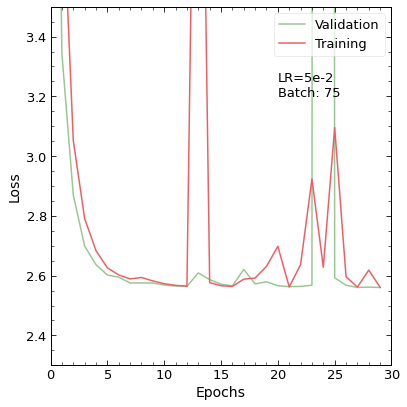

In [48]:
fig = plt.figure(figsize=(6,6))
plt.plot(pNet_history2.history['val_loss'], label="Validation")
plt.plot(pNet_history2.history['loss'], label="Training")
# plt.yscale('log')
plt.ylim(2.3,3.5)
plt.yticks(fontsize=13)
plt.xlim(0,len(pNet_history1.history['loss']))
plt.xticks(fontsize=13)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='upper right', ncol=1, frameon=True, fancybox=True)
plt.text(20, 3.25, 'LR=5e-2', fontsize=13)
plt.text(20, 3.2, 'Batch: 75', fontsize=13)
plt.tight_layout()
# plt.savefig('Plots/November21/LossCurves_Continuous_halfsizePNet_LR5e-2_batch75_2021-11-22.png', format='png')
plt.show()

### Predictions

In [52]:
t0 = t.time()
predictions = russ_model3.predict(dat_test)
print(predictions.shape)
t1 = t.time()
print('Time to make predictions: '+str(t1-t0)+' (s)')

(7500, 1506, 1)
Time to make predictions: 10.059530258178711 (s)


In [57]:
for i in range(1506):
    print(predictions[0,i,:])

[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]
[0.82498884]